
# Employee Attrition Analytics — Lean Notebook

This notebook demonstrates a minimal, high-signal pipeline aligned with DA roles:
- **Data audit** (shape, dtypes, missing, duplicates, ranges)
- **EDA** (class balance bar, correlation heatmap)
- **Statistical tests** (Chi-square for OverTime×Attrition, Mann–Whitney for MonthlyIncome)
- **Feature selection** (RFE with Logistic Regression — top 5 features)
- **Model** (Logistic Regression with `class_weight='balanced'`)
- **Metrics** (Accuracy, Precision, Recall, F1, ROC-AUC) + **confusion matrix**

> Dataset used: `ibm_hr_attrition.csv` (sanitized column names).


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import RFE
from scipy.stats import chi2_contingency, mannwhitneyu

# Load dataset
csv_path = r"sql/ibm_hr_attrition.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes.head(20))
print("\nMissing (top 20):\n", df.isnull().sum().sort_values(ascending=False).head(20))
print("\nDuplicate rows:", df.duplicated().sum())

# Range sanity checks
print("\nRanges:")
print("Age:", df['Age'].min(), "to", df['Age'].max())
print("MonthlyIncome:", df['MonthlyIncome'].min(), "to", df['MonthlyIncome'].max())
print("YearsAtCompany:", df['YearsAtCompany'].min(), "to", df['YearsAtCompany'].max())


Shape: (1470, 35)

Dtypes:
 Age                         int64
Attrition                  object
BusinessTravel             object
DailyRate                   int64
Department                 object
DistanceFromHome            int64
Education                   int64
EducationField             object
EmployeeCount               int64
EmployeeNumber              int64
EnvironmentSatisfaction     int64
Gender                     object
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                    object
JobSatisfaction             int64
MaritalStatus              object
MonthlyIncome               int64
MonthlyRate                 int64
dtype: object

Missing (top 20):
 Age                         0
StandardHours               0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel  

## EDA: Class balance and correlation heatmap

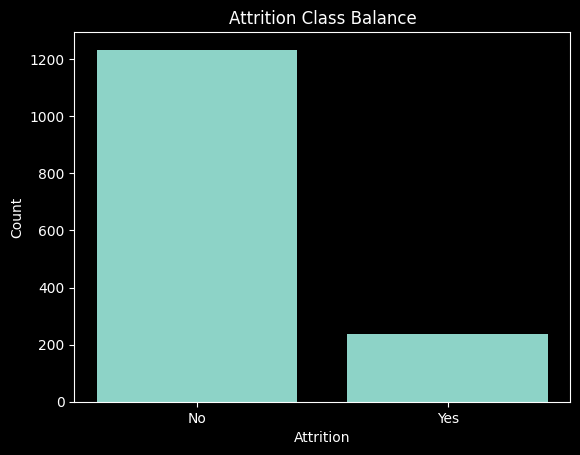

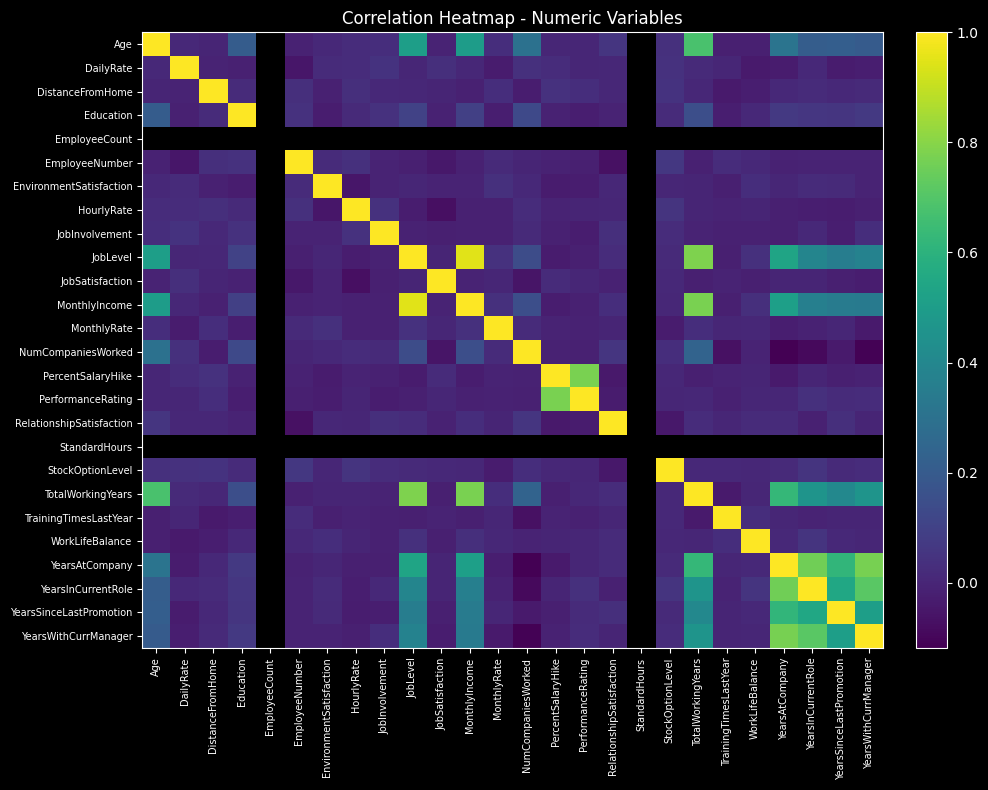

In [3]:

# Class balance
counts = df['Attrition'].value_counts()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Attrition Class Balance")
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.show()

# Correlation heatmap for numeric variables
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=7)
plt.title("Correlation Heatmap - Numeric Variables")
plt.tight_layout()
plt.show()


## Statistical tests

In [4]:

# Chi-square: OverTime x Attrition
contingency = pd.crosstab(df['OverTime'], df['Attrition'])
chi2, p_chi2, dof, expected = chi2_contingency(contingency)
print("Chi-square (OverTime x Attrition): chi2=%.4f, dof=%d, p=%.6g" % (chi2, dof, p_chi2))

# Mann–Whitney U: MonthlyIncome vs Attrition
income_yes = df[df['Attrition'] == 'Yes']['MonthlyIncome']
income_no = df[df['Attrition'] == 'No']['MonthlyIncome']
u_stat, p_mwu = mannwhitneyu(income_yes, income_no, alternative='two-sided')
effect_size = (income_yes.mean() - income_no.mean()) / df['MonthlyIncome'].std()
print("Mann–Whitney U (MonthlyIncome vs Attrition): U=%.4f, p=%.6g, effect_size=%.4f" % (u_stat, p_mwu, effect_size))


Chi-square (OverTime x Attrition): chi2=87.5643, dof=1, p=8.15842e-21
Mann–Whitney U (MonthlyIncome vs Attrition): U=100620.5000, p=2.95083e-14, effect_size=-0.4345


## Feature selection (RFE with Logistic Regression)

In [5]:

# Prepare model matrix
df_model = df.copy()
df_model['Attrition'] = df_model['Attrition'].map({'Yes': 1, 'No': 0})
y = df_model['Attrition']
X = pd.get_dummies(df_model.drop('Attrition', axis=1), drop_first=True)

lr_for_rfe = LogisticRegression(max_iter=500, solver='liblinear')
rfe = RFE(lr_for_rfe, n_features_to_select=5)
rfe.fit(X, y)
top_features = X.columns[rfe.support_]
print("Top 5 features (RFE):")
for i, f in enumerate(top_features, 1):
    print(f"{i}. {f}")


Top 5 features (RFE):
1. JobRole_Manager
2. JobRole_Research Director
3. JobRole_Sales Representative
4. MaritalStatus_Single
5. OverTime_Yes


## Logistic Regression (class-weighted) + Metrics

Metrics:
Accuracy: 0.7449
Precision: 0.3372
Recall: 0.6170
F1: 0.4361
ROC_AUC: 0.7958


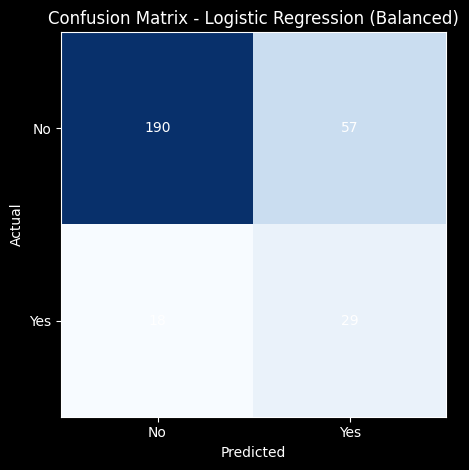

In [6]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale (with_mean=False for sparse one-hot)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with class weights
lr_bal = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced')
lr_bal.fit(X_train_scaled, y_train)
y_pred = lr_bal.predict(X_test_scaled)
y_prob = lr_bal.predict_proba(X_test_scaled)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC_AUC: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (Balanced)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0,1], ['No','Yes'])
plt.yticks([0,1], ['No','Yes'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()


In [7]:
# === Coefficients table (robust to variable names) ===
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import inspect

# 1) find a fitted LogisticRegression object in the global namespace
candidates = []
for name, obj in globals().items():
    if isinstance(obj, LogisticRegression):
        # crude fitted check: coef_ exists
        if hasattr(obj, "coef_"):
            candidates.append((name, obj))

if not candidates:
    raise RuntimeError("No fitted LogisticRegression found. Train your model first.")

# pick the last fitted LR found (usually your final model)
model_name, clf = candidates[-1]
print(f"Using fitted LogisticRegression from variable: {model_name}")

# 2) get feature names
if "X_train" in globals() and hasattr(X_train, "columns"):
    feature_names = list(X_train.columns)
elif "X" in globals() and hasattr(X, "columns"):
    feature_names = list(X.columns)
else:
    # fall back to generic names based on the coef length
    n_feats = clf.coef_.shape[1]
    feature_names = [f"feature_{i}" for i in range(n_feats)]

# 3) build coefficient table
coef = clf.coef_.ravel()
coef_s = pd.Series(coef, index=feature_names)
coef_abs_sorted = coef_s.reindex(coef_s.abs().sort_values(ascending=False).index)

coef_df = pd.DataFrame({
    "feature": coef_abs_sorted.index,
    "coef": coef_abs_sorted.values
})
coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df["direction"] = np.where(coef_df["coef"] > 0, "↑ risk", "↓ risk")

# 4) preview and save
display(coef_df.head(20))
out_path = "model_coefficients.csv"
coef_df.to_csv(out_path, index=False)
print(f"Saved full coefficients table to {out_path}")


Using fitted LogisticRegression from variable: lr_bal


,feature,coef,odds_ratio,direction
0,JobRole_Laboratory Technician,0.811965,2.252330,↑ risk
1,OverTime_Yes,0.773437,2.167202,↑ risk
2,BusinessTravel_Travel_Frequently,0.721960,2.058463,↑ risk
3,JobLevel,0.665032,1.944553,↑ risk
4,TotalWorkingYears,-0.652635,0.520672,↓ risk
5,JobRole_Sales Representative,0.536362,1.709776,↑ risk
6,BusinessTravel_Travel_Rarely,0.512698,1.669790,↑ risk
7,YearsSinceLastPromotion,0.496890,1.643601,↑ risk
8,Department_Sales,0.495537,1.641379,↑ risk
9,EducationField_Life Sciences,-0.486569,0.614732,↓ risk


Saved full coefficients table to model_coefficients.csv


In [1]:
import pandas as pd

# 1) Load saved coefficients
coef = pd.read_csv("model_coefficients.csv")

# 2) Top 10 by absolute impact (clean table)
coef["abs_coef"] = coef["coef"].abs()
top10 = (coef.sort_values("abs_coef", ascending=False)
              .head(10)[["feature", "coef", "odds_ratio", "direction"]])

# Nice formatting for display
display(top10.style
        .format({"coef": "{:.3f}", "odds_ratio": "{:.2f}"})
        .hide(axis="index"))

# 3) Quick talking points (top risk ↑ and protective ↓)
risk_up = coef[coef["coef"] > 0].sort_values("coef", ascending=False).head(3)
protect = coef[coef["coef"] < 0].sort_values("coef", ascending=True).head(3)

print("\nTop ↑ risk drivers (odds ratios):")
for _, r in risk_up.iterrows():
    print(f"- {r['feature']}: OR {r['odds_ratio']:.2f}")

print("\nTop protective drivers (odds ratios):")
for _, r in protect.iterrows():
    print(f"- {r['feature']}: OR {r['odds_ratio']:.2f}")

print("\nInterpretation: OR > 1 increases odds of attrition; OR < 1 decreases odds (all else equal).")


feature,coef,odds_ratio,direction
JobRole_Laboratory Technician,0.812,2.25,↑ risk
OverTime_Yes,0.773,2.17,↑ risk
BusinessTravel_Travel_Frequently,0.722,2.06,↑ risk
JobLevel,0.665,1.94,↑ risk
TotalWorkingYears,-0.653,0.52,↓ risk
JobRole_Sales Representative,0.536,1.71,↑ risk
BusinessTravel_Travel_Rarely,0.513,1.67,↑ risk
YearsSinceLastPromotion,0.497,1.64,↑ risk
Department_Sales,0.496,1.64,↑ risk
EducationField_Life Sciences,-0.487,0.61,↓ risk



Top ↑ risk drivers (odds ratios):
- JobRole_Laboratory Technician: OR 2.25
- OverTime_Yes: OR 2.17
- BusinessTravel_Travel_Frequently: OR 2.06

Top protective drivers (odds ratios):
- TotalWorkingYears: OR 0.52
- EducationField_Life Sciences: OR 0.61
- YearsWithCurrManager: OR 0.63

Interpretation: OR > 1 increases odds of attrition; OR < 1 decreases odds (all else equal).
